### NOte - 
Task2 code was adepeted from the following link - https://github.com/NUS-HPC-AI-Lab/PAD

Adepted version of it for MNIST dataset and computation limits can be found in task2 folder

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torchvision.utils import save_image
from thop import profile
import sys
from PIL import Image
# hide warnings
import warnings
warnings.filterwarnings("ignore")

figures_dir = '../report/figures/'

from utils import TensorDataset

print(f"PyTorch Version: {torch.__version__}")
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(0)
    properties = torch.cuda.get_device_properties(0)
    compute_capability = f"{properties.major}.{properties.minor}"
    total_memory = properties.total_memory / 1024**3

    print(f"CUDA Device: {device_name}")
    print(f"CUDA Compute Capability: {compute_capability}")
    print(f"Total Memory: {total_memory:.2f} GB")
else:
    device = torch.device("cpu")
    print("GPU is not available")


PyTorch Version: 2.4.1+cu121
CUDA Device: NVIDIA GeForce RTX 2060
CUDA Compute Capability: 7.5
Total Memory: 5.61 GB


In [3]:
def get_syn_dataset (syn_images, syn_labels):
    img = torch.load(syn_images)
    label = torch.load(syn_labels)
    label = label.argmax(dim=1)
    # l
    syn_dataset = TensorDataset(img, label)
    
    channel = img.shape[1]
    num_classes = label.max().item() + 1
    im_size = (img.shape[2], img.shape[3])

    dataloader = torch.utils.data.DataLoader(syn_dataset, batch_size=10, shuffle=True)
    return syn_dataset, channel, num_classes, im_size, dataloader

In [4]:
syn_images = "./task2/PAD/distill/logged_files/MNIST/10/ConvNet/RANDOM/Normal/images_best.pt"
syn_labels = "./task2/PAD/distill/logged_files/MNIST/10/ConvNet/RANDOM/Normal/labels_best.pt"
syn_dataset, channel, num_classes, im_size, dataloader = get_syn_dataset(syn_images, syn_labels)

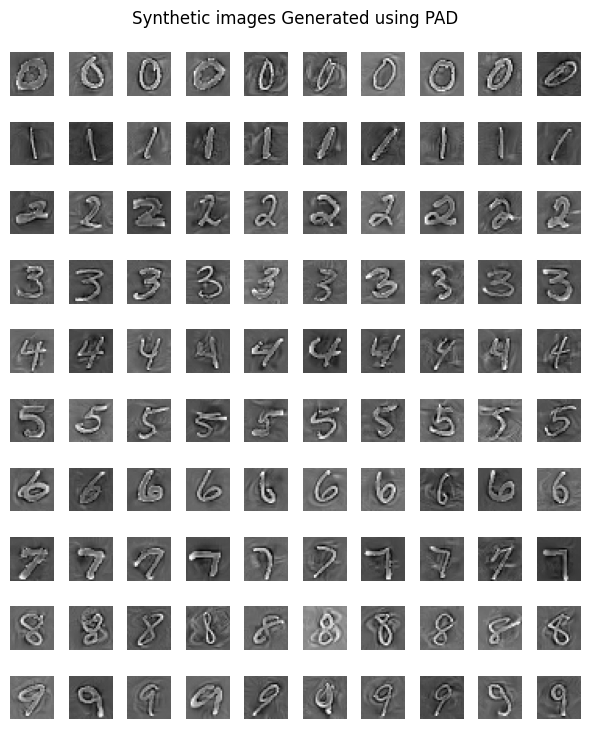

In [5]:
imgs = torch.load(syn_images)
lbls = torch.load(syn_labels)

# find index of highet label in that row
lbls = lbls.argmax(dim=1)

fig, axes = plt.subplots(10, 10, figsize=(6, 1.5*5))
for i, ax in enumerate(axes.flat):
    ax.imshow(imgs[i].cpu().numpy().squeeze(), cmap="gray")
    ax.axis('off')
plt.suptitle("Synthetic images Generated using PAD")
plt.tight_layout()
plt.savefig(figures_dir + "synthetic_images_task2.png")

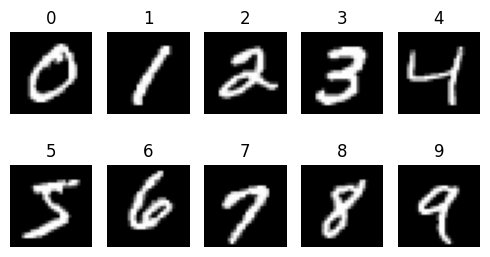

In [6]:
from utils import get_dataset
# load MNIST dataset from utils
(
    channel,
    im_size,
    num_classes,
    class_names,
    mean,
    std,
    train_MNIST_dataset,
    test_MNIST_dataset,
    test_MNIST_dataloader,
    train_MNIST_dataloader,
) = get_dataset("MNIST", "../datasets")

# visualize 10 classes of MNIST (2 by 5)
fig, axes = plt.subplots(2, 5, figsize=(5, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(
        train_MNIST_dataset.data[train_MNIST_dataset.targets == i][0], cmap="gray"
    )
    ax.set_title(f"{i}")
    ax.axis("off")
plt.tight_layout()
plt.show()
#plt.savefig(figures_dir + "MNIST_dataset.png", dpi=300)

In [7]:
from utils import get_network, epoch_S, get_flops
from tqdm.auto import tqdm
import time

syn_dataset, channel, num_classes, im_size, dataloader = get_syn_dataset(syn_images, syn_labels)

print("Synthetic Dataset")
print(f"Channel: {channel}")
print(f"Number of classes: {num_classes}")
print(f"Image size: {im_size}")
print(f"dataloader: {len(dataloader)}")

Synthetic Dataset
Channel: 1
Number of classes: 10
Image size: (28, 28)
dataloader: 10


In [8]:
ConvNet3 = get_network('ConvNetD3', channel, num_classes, im_size)
n_epochs = 20
lr = 0.01
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(ConvNet3.parameters(), lr=lr)
train_acc, test_acc = [], []
trainLoader = train_MNIST_dataloader
testLoader = test_MNIST_dataloader

progress_bar = tqdm(
    total=n_epochs*len(trainLoader) + n_epochs*len(testLoader),
    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]',
    unit = 'step',
)
start_time = time.time()
for ep in range (n_epochs):
    train_loss_avg, train_acc_avg = epoch_S(
        'train',
        trainLoader,
        ConvNet3,
        optimizer,
        criterion,
        device,
        progress_bar,
        start_time,
    )
        
    test_loss_avg, test_acc_avg = epoch_S(
        'test',
        testLoader,
        ConvNet3,
        optimizer,
        criterion,
        device,
        progress_bar,
        start_time,
    )
    train_acc.append(train_acc_avg)
    test_acc.append(test_acc_avg)

ConvNet3_train_acc = train_acc
ConvNet3_test_acc = test_acc

flops, _ = get_flops(ConvNet3, testLoader, device)
print("FLOPS: {:,}".format(flops))

## Runtime      255.49 s
## FLOPS        48,429,056

  0%|          | 0/43760 [00:00<?, ?step/s]

FLOPS: 48,429,056.0


In [13]:
output_dir = '../output/'

# function to get syn dataset from the output file
def get_syn_dataset_task1 (sym_name):
    syn_dataset_file = output_dir + sym_name
    results = torch.load(syn_dataset_file, weights_only=True)
    syn_imgs = results[0][0]
    syn_labels = results[0][1]

    syn_dataset = TensorDataset(syn_imgs, syn_labels)
    channel = syn_imgs.shape[1]
    num_classes = syn_labels.max().item() + 1
    im_size = (syn_imgs.shape[2], syn_imgs.shape[3])

    dataloader = torch.utils.data.DataLoader(syn_dataset, batch_size=32, shuffle=True)
    return syn_dataset, channel, num_classes, im_size, dataloader

syn_dataset, channel, num_classes, im_size, dataloader = get_syn_dataset_task1('MNIST_real_res.pt')
ConvNet3Syn = get_network('ConvNetD3', channel, num_classes, im_size)
n_epochs = 20
lr = 0.01
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(ConvNet3Syn.parameters(), lr=lr)
train_acc, test_acc = [], []
trainLoader = dataloader
testLoader = test_MNIST_dataloader

progress_bar = tqdm(
    total=n_epochs*len(trainLoader) + n_epochs*len(testLoader),
    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]',
    unit = 'step',
)
start_time = time.time()
for ep in range (n_epochs):
    train_loss_avg, train_acc_avg = epoch_S(
        'train',
        trainLoader,
        ConvNet3Syn,
        optimizer,
        criterion,
        device,
        progress_bar,
        start_time,
    )
        
    test_loss_avg, test_acc_avg = epoch_S(
        'test',
        testLoader,
        ConvNet3Syn,
        optimizer,
        criterion,
        device,
        progress_bar,
        start_time,
    )
    train_acc.append(train_acc_avg)
    test_acc.append(test_acc_avg)

ConvNet3Syn_train_acc = train_acc
ConvNet3Syn_test_acc = test_acc

flops, _ = get_flops(ConvNet3Syn, testLoader, device)
print("FLOPS: {:,}".format(flops))

## Runtime      32.27 s
## FLOPS        48,429,056

  0%|          | 0/6340 [00:00<?, ?step/s]

FLOPS: 48,429,056.0


In [14]:


syn_dataset, channel, num_classes, im_size, dataloader = get_syn_dataset(syn_images, syn_labels)
ConvNet3Syn = get_network('ConvNetD3', channel, num_classes, im_size)
n_epochs = 20
lr = 0.01
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(ConvNet3Syn.parameters(), lr=lr)
train_acc, test_acc = [], []
trainLoader = dataloader
testLoader = test_MNIST_dataloader

progress_bar = tqdm(
    total=n_epochs*len(trainLoader) + n_epochs*len(testLoader),
    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]',
    unit = 'step',
)
start_time = time.time()
for ep in range (n_epochs):
    train_loss_avg, train_acc_avg = epoch_S(
        'train',
        trainLoader,
        ConvNet3Syn,
        optimizer,
        criterion,
        device,
        progress_bar,
        start_time,
    )
        
    test_loss_avg, test_acc_avg = epoch_S(
        'test',
        testLoader,
        ConvNet3Syn,
        optimizer,
        criterion,
        device,
        progress_bar,
        start_time,
    )
    train_acc.append(train_acc_avg)
    test_acc.append(test_acc_avg)

pad_train_acc = train_acc
pad_test_acc = test_acc

flops, _ = get_flops(ConvNet3Syn, testLoader, device)
print("FLOPS: {:,}".format(flops))

## Runtime      32.27 s
## FLOPS        48,429,056

  0%|          | 0/6460 [00:00<?, ?step/s]

FLOPS: 48,429,056.0


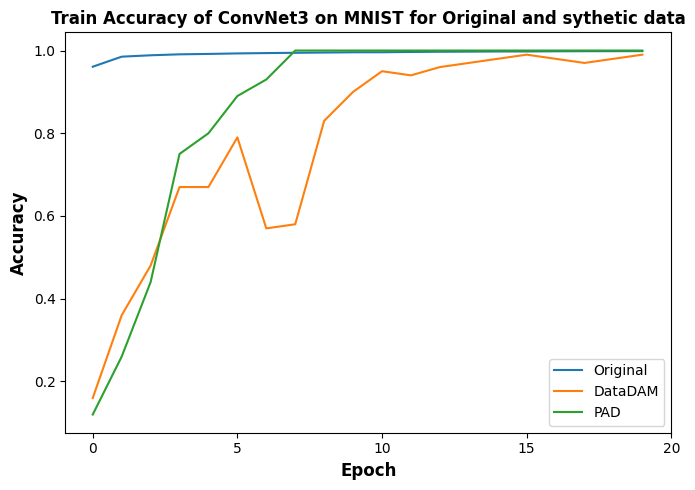

In [18]:
plt.figure(figsize=(7, 5))  # Set figure size

# compare ConvNet3, ConvNet3Syn, and PAD  test accuracy
plt.plot(ConvNet3_train_acc, label="Original")
plt.plot(ConvNet3Syn_train_acc, label="DataDAM")
plt.plot(pad_train_acc, label="PAD")
plt.grid(False)
plt.xticks(np.arange(0, n_epochs+1, 5))

plt.xlabel("Epoch", fontsize=12, fontweight='bold')
plt.ylabel("Accuracy", fontsize=12, fontweight='bold')
plt.title("Train Accuracy of ConvNet3 on MNIST for Original and sythetic data", fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.savefig(figures_dir + "train_acc_task2.png", dpi=300)
plt.show()

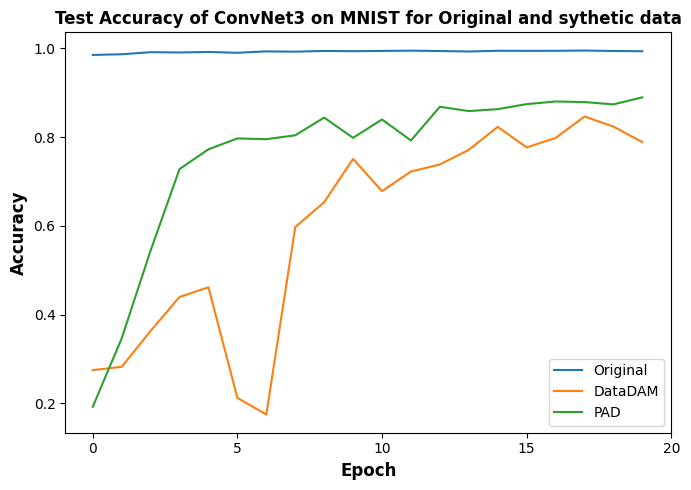

In [19]:
plt.figure(figsize=(7, 5))  # Set figure size

# compare ConvNet3, ConvNet3Syn, and PAD  test accuracy
plt.plot(ConvNet3_test_acc, label="Original")
plt.plot(ConvNet3Syn_test_acc, label="DataDAM")
plt.plot(pad_test_acc, label="PAD")
plt.grid(False)
plt.xticks(np.arange(0, n_epochs+1, 5))

plt.xlabel("Epoch", fontsize=12, fontweight='bold')
plt.ylabel("Accuracy", fontsize=12, fontweight='bold')
plt.title("Test Accuracy of ConvNet3 on MNIST for Original and sythetic data", fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.savefig(figures_dir + "test_acc_task2.png", dpi=300)

plt.show()

In [ ]:
# plot ConvNet3Syn_train_acc and ConvNet3Syn_test_acc
plt.plot(pad_train_acc, label="train")
plt.plot(pad_test_acc, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ConvNet3Syn")
plt.legend()
plt.show()